<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/Explanations/EvaluatingExplanaitons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Up the Google Environment

Change the following paths to the ones in your gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/modelo_forecasting_xai

!ls

/content/gdrive/MyDrive/modelo_forecasting_xai
final_data.csv	model_bilstm


In [ ]:
data_dir = "/content/gdrive/MyDrive/modelo_forecasting_xai"


### Lime and Shap installation

In [ ]:
!pip install shap lime

## Code

```tf.compat.v1.disable_v2_behavior()```

Needs to be used in order to generate shap and lime explanations!

```yf.download('^BVSP', '2007-01-01', '2023-10-17')```

Calls the Brazilian Stockmarket Data from Yahoo Finances API

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU, Reshape
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import shap
#from tensorflow.compat.v1.keras.backend import get_session

tf.compat.v1.disable_v2_behavior()

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data




/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
Instructions for updating:
non-resource variables are not supported in the long term
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100
...,...,...,...,...,...,...
2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400
2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500
2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800


In [ ]:
# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-10-20')

# Display the first few rows of the downloaded data
exchange_rate_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-01,2.1310,2.1325,2.1310,2.1325,2.1325,0
2007-01-02,2.1335,2.1432,2.1295,2.1310,2.1310,0
2007-01-03,2.1310,2.1351,2.1278,2.1345,2.1345,0
2007-01-04,2.1345,2.1430,2.1345,2.1390,2.1390,0
2007-01-05,2.1390,2.1525,2.1345,2.1470,2.1470,0


In [ ]:
exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})
exchange_rate_data.head(10)

,Date,USD
0,2007-01-01,2.1325
1,2007-01-02,2.1310
2,2007-01-03,2.1345
3,2007-01-04,2.1390
4,2007-01-05,2.1470
5,2007-01-08,2.1465
6,2007-01-09,2.1490
7,2007-01-10,2.1496
8,2007-01-11,2.1415
9,2007-01-12,2.1370


#### Holidays and observance days Data, from the date-holidays module in javascript.

 - More details on the JS implementation on this link to the [github code](https://github.com/marreapato/Forecasting_Paper_XAI/blob/main/Holidays/holidays.js).

 - Treatment of holidays data was done in this [link](https://github.com/marreapato/Forecasting_Paper_XAI/blob/main/Holidays/TreatingHolidaysData.ipynb). Observance Days are important dates that may not be a holidays, such as Valentine's day or Mothers Day, Optional Holidays include only holidays that are optional (i.e not obliged by law).

In [ ]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
feriados

,Date,4_observance,4_optional,4_public
0,2007-01-01,0,0,1
1,2007-01-02,0,0,1
2,2007-02-17,0,1,0
3,2007-02-18,0,1,0
4,2007-02-19,0,1,0
...,...,...,...,...
697,2024-12-25,0,1,0
698,2024-12-25,0,0,1
699,2024-12-26,0,0,1
700,2024-12-31,0,1,0


In [ ]:
data.reset_index(inplace=True)


In [ ]:
feriados['Date']=feriados.Date.astype('datetime64[ns]')

In [ ]:
data=data.merge(feriados, on='Date', how='left')

In [ ]:
data['4_observance'] = data['4_observance'].fillna(0)
data['4_public'] = data['4_public'].fillna(0)
data['4_optional'] = data['4_optional'].fillna(0)

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0


In [ ]:
data=data.merge(exchange_rate_data, on='Date', how='left')

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public,USD
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0,2.1310
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0,2.1345
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0,2.1390
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0,2.1470
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0,2.1465
...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400,0.0,0.0,0.0,5.1457
4153,2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500,0.0,0.0,0.0,5.1352
4154,2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800,0.0,0.0,0.0,5.0510
4155,2023-10-13,117050.0,117070.0,115658.0,115754.0,115754.0,10609300,0.0,0.0,1.0,5.0459


### Feature Engineering to reduce dimensionality

The Variable variation_low_high is created to reduce dimensionality and capture the volatility of the market in the previous days

In [ ]:
data['variation_low_high'] = ((data['High']-data['Low'])/data['Low'])*100

In [ ]:
data = data.drop('Adj Close',axis = 1)
data = data.drop('Open',axis = 1)
data = data.drop('High',axis = 1)
data = data.drop('Low',axis = 1)
data = data.drop('Volume',axis = 1)

In [ ]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)
selic

,Date,selic
0,24/01/2007,1
1,07/03/2007,1
2,18/04/2007,1
3,06/06/2007,1
4,18/07/2007,1
...,...,...
131,21/06/2023,1
132,02/08/2023,1
133,20/09/2023,1
134,01/11/2023,1


In [ ]:
selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.


0      2007-01-24
1      2007-07-03
2      2007-04-18
3      2007-06-06
4      2007-07-18
          ...    
131    2023-06-21
132    2023-02-08
133    2023-09-20
134    2023-01-11
135    2023-12-13
Name: Date, Length: 136, dtype: object

In [ ]:
data=data.merge(selic, on='Date', how='left')
data['selic'] = data['selic'].fillna(0)
data.head()#SELIC WAS ADDED HERE

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0


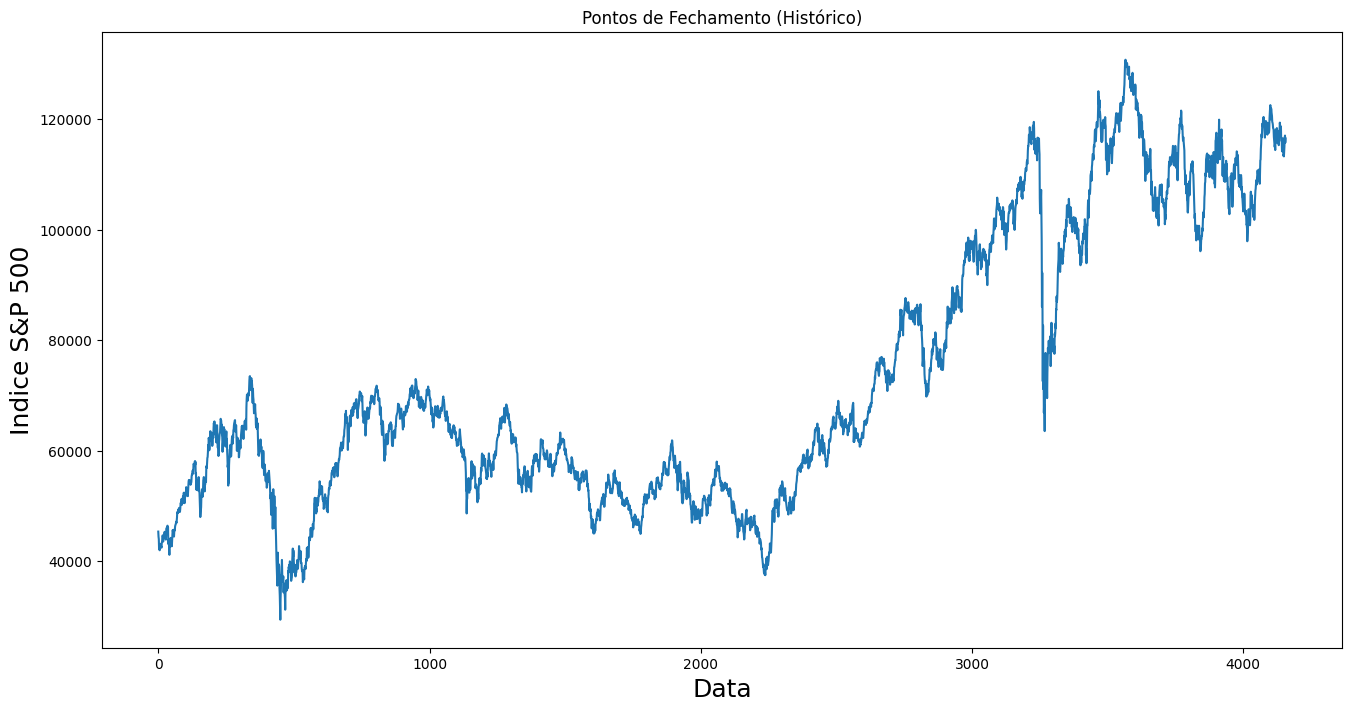

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice S&P 500",fontsize=18)
plt.show()

In [ ]:
look_back=6#lookback window

In [ ]:
#split train test data
last_rows=(len(data['Close'])-look_back)-int((len(data['Close'].values.reshape(-1, 1)[:])-look_back)*0.8)
last_rows

831

In [ ]:
size_of_slice=round((len(data['Close'].values.reshape(-1, 1)[:]))*0.8)
size_of_slice=size_of_slice+(len(data)-(size_of_slice+last_rows))
size_of_slice



3326

In [ ]:
data['Close']

0        45383.0
1        44445.0
2        44020.0
3        42245.0
4        42830.0
          ...   
4152    115156.0
4153    116737.0
4154    117051.0
4155    115754.0
4156    116534.0
Name: Close, Length: 4157, dtype: float64

Lagged Data for XAI Comparison

In [ ]:
train_datanscalxai = data.iloc[0:size_of_slice]
test_datanscalxai = data.iloc[size_of_slice:size_of_slice+last_rows]

In [ ]:
data.columns

Index(['Date', 'Close', '4_observance', '4_optional', '4_public', 'USD',
       'variation_low_high', 'selic'],
      dtype='object')

In [ ]:
train_datanscalxai.head()

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0


In [ ]:
data_trainxai=train_datanscalxai.append(test_datanscalxai)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
data_trainxai.shape

(4157, 8)

In [ ]:
# Creating lagged dataframe

def create_lagged_dataframe(data, lags, include_lag0=False,column_name='Close'):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data[column_name]

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}{column_name}'] = lagged_data[column_name].shift(lag)

    return lagged_data



# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_datansc = create_lagged_dataframe(data_trainxai, look_back, include_lag0)


In [ ]:
lagged_datansc = create_lagged_dataframe(lagged_datansc, look_back, include_lag0,column_name = 'variation_low_high')
lagged_datansc = create_lagged_dataframe(lagged_datansc, look_back, include_lag0,column_name = 'USD')

In [ ]:
lagged_datansc

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic,lag1Close,lag2Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0,45383.0,NaN,...,NaN,NaN,NaN,NaN,2.1310,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0,44445.0,45383.0,...,NaN,NaN,NaN,NaN,2.1345,2.1310,NaN,NaN,NaN,NaN
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0,44020.0,44445.0,...,2.050544,NaN,NaN,NaN,2.1390,2.1345,2.1310,NaN,NaN,NaN
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0,42245.0,44020.0,...,2.472676,2.050544,NaN,NaN,2.1470,2.1390,2.1345,2.1310,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,115156.0,0.0,0.0,0.0,5.1457,1.561068,0.0,114170.0,113284.0,...,0.919176,1.683591,1.665200,0.999637,5.1650,5.1546,5.1663,5.0615,5.0428,5.0328
4153,2023-10-10,116737.0,0.0,0.0,0.0,5.1352,1.512704,0.0,115156.0,114170.0,...,1.467548,0.919176,1.683591,1.665200,5.1457,5.1650,5.1546,5.1663,5.0615,5.0428
4154,2023-10-11,117051.0,0.0,0.0,0.0,5.0510,0.746789,0.0,116737.0,115156.0,...,2.591421,1.467548,0.919176,1.683591,5.1352,5.1457,5.1650,5.1546,5.1663,5.0615
4155,2023-10-13,115754.0,0.0,0.0,1.0,5.0459,1.220841,0.0,117051.0,116737.0,...,1.561068,2.591421,1.467548,0.919176,5.0510,5.1352,5.1457,5.1650,5.1546,5.1663


In [ ]:
lagged_datansc= lagged_datansc.drop(columns=['USD','variation_low_high'])

In [ ]:
lagged_datansc = lagged_datansc.dropna()  # Drop rows with NaN values

train_sizensc = int(len(lagged_datansc) * 0.8)
test_sizensc = len(lagged_datansc) - train_sizensc
trainnsc, testnsc = lagged_datansc[0:train_sizensc], lagged_datansc[train_sizensc:len(data)]


In [ ]:
lagged_datansc.head(-1)

,Date,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,2007-01-10,42336.0,0.0,0.0,0.0,0.0,42007.0,42830.0,42245.0,44020.0,...,4.556452,1.877450,2.472676,2.050544,2.1490,2.1465,2.1470,2.1390,2.1345,2.1310
7,2007-01-11,42670.0,0.0,0.0,0.0,0.0,42336.0,42007.0,42830.0,42245.0,...,1.855543,4.556452,1.877450,2.472676,2.1496,2.1490,2.1465,2.1470,2.1390,2.1345
8,2007-01-12,43095.0,0.0,0.0,0.0,0.0,42670.0,42336.0,42007.0,42830.0,...,3.771900,1.855543,4.556452,1.877450,2.1415,2.1496,2.1490,2.1465,2.1470,2.1390
9,2007-01-15,42919.0,0.0,0.0,0.0,0.0,43095.0,42670.0,42336.0,42007.0,...,2.592934,3.771900,1.855543,4.556452,2.1370,2.1415,2.1496,2.1490,2.1465,2.1470
10,2007-01-16,42624.0,0.0,0.0,0.0,0.0,42919.0,43095.0,42670.0,42336.0,...,2.832618,2.592934,3.771900,1.855543,2.1368,2.1370,2.1415,2.1496,2.1490,2.1465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,2023-10-06,114170.0,0.0,0.0,0.0,0.0,113284.0,113607.0,113419.0,115057.0,...,1.683591,1.665200,0.999637,0.995549,5.1546,5.1663,5.0615,5.0428,5.0328,5.0422
4152,2023-10-09,115156.0,0.0,0.0,0.0,0.0,114170.0,113284.0,113607.0,113419.0,...,0.919176,1.683591,1.665200,0.999637,5.1650,5.1546,5.1663,5.0615,5.0428,5.0328
4153,2023-10-10,116737.0,0.0,0.0,0.0,0.0,115156.0,114170.0,113284.0,113607.0,...,1.467548,0.919176,1.683591,1.665200,5.1457,5.1650,5.1546,5.1663,5.0615,5.0428
4154,2023-10-11,117051.0,0.0,0.0,0.0,0.0,116737.0,115156.0,114170.0,113284.0,...,2.591421,1.467548,0.919176,1.683591,5.1352,5.1457,5.1650,5.1546,5.1663,5.0615


In [ ]:
trainXnsc= trainnsc.drop(columns=['Close','Date']).values
testXnsc = testnsc.drop(columns=['Close','Date']).values
trainYnsc= trainnsc['Close'].values
testYnsc= testnsc['Close'].values

print("TrainX shape:", trainXnsc.shape)
print("TrainY shape:", trainYnsc.shape)
print("TestX shape:", testXnsc.shape)
print("TestY shape:", testYnsc.shape)

TrainX shape: (3237, 22)
TrainY shape: (3237,)
TestX shape: (810, 22)
TestY shape: (810,)


After

In [ ]:
# Normalize the data
closescaler = MinMaxScaler()

data_train=pd.DataFrame(closescaler.fit_transform(data['Close'].values[0:size_of_slice].reshape(-1, 1)),
                        columns=['Close'],index=data['Close'].index[0:size_of_slice])#use fit only in training that is wrong
data_test=pd.DataFrame(closescaler.transform(data['Close'].values[size_of_slice:size_of_slice+last_rows].reshape(-1, 1)),
                       columns=['Close'],index=data['Close'].index[size_of_slice:size_of_slice+last_rows])#use fit only in training that is wrong

In [ ]:
train_datanscal = data.iloc[0:size_of_slice]
test_datanscal = data.iloc[size_of_slice:size_of_slice+last_rows]

In [ ]:
data.columns

Index(['Date', 'Close', '4_observance', '4_optional', '4_public', 'USD',
       'variation_low_high', 'selic'],
      dtype='object')

In [ ]:
# Normalize the data
scaler = MinMaxScaler()

train_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = scaler.fit_transform(train_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
train_datanscal.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,0.177017,0.0,0.0,1.0,0.137225,0.073612,0.0
1,2007-01-03,0.166606,0.0,0.0,0.0,0.138029,0.091220,0.0
2,2007-01-04,0.161888,0.0,0.0,0.0,0.139063,0.066392,0.0
3,2007-01-05,0.142186,0.0,0.0,0.0,0.140901,0.178138,0.0
4,2007-01-08,0.148680,0.0,0.0,0.0,0.140786,0.065478,0.0


In [ ]:
test_datanscal[['variation_low_high','Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = scaler.transform(test_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
test_datanscal.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
3326,2020-06-16,0.711443,0.0,0.0,0.0,0.831554,0.115807,0.0
3327,2020-06-17,0.733819,0.0,0.0,0.0,0.852321,0.125438,1.0
3328,2020-06-18,0.740235,0.0,0.0,0.0,0.848715,0.094322,0.0
3329,2020-06-19,0.745197,0.0,0.0,0.0,0.883015,0.060562,0.0
3330,2020-06-22,0.731477,0.0,0.0,0.0,0.867576,0.076059,0.0


In [ ]:
order_standardize = ['variation_low_high','Close',
       '4_observance', '4_optional', '4_public','selic','USD']

In [ ]:
data_train=train_datanscal.append(test_datanscal)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
data_train.shape

(4157, 8)

In [ ]:
len(data_train)==len(data)

True

In [ ]:
data_train.shape

(4157, 8)

In [ ]:
# Normalize the data
#scaler = MinMaxScaler()
#data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong


def create_lagged_dataframe(data, lags, include_lag0=False,column_name='Close'):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data[column_name]

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}{column_name}'] = lagged_data[column_name].shift(lag)

    return lagged_data
# Split the data into train and test sets


# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data_train, look_back, include_lag0)


In [ ]:
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'variation_low_high')
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'USD')

In [ ]:
lagged_data

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic,lag1Close,lag2Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
0,2007-01-02,0.177017,0.0,0.0,1.0,0.137225,0.073612,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,0.166606,0.0,0.0,0.0,0.138029,0.091220,0.0,0.177017,NaN,...,NaN,NaN,NaN,NaN,0.137225,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,0.161888,0.0,0.0,0.0,0.139063,0.066392,0.0,0.166606,0.177017,...,NaN,NaN,NaN,NaN,0.138029,0.137225,NaN,NaN,NaN,NaN
3,2007-01-05,0.142186,0.0,0.0,0.0,0.140901,0.178138,0.0,0.161888,0.166606,...,0.073612,NaN,NaN,NaN,0.139063,0.138029,0.137225,NaN,NaN,NaN
4,2007-01-08,0.148680,0.0,0.0,0.0,0.140786,0.065478,0.0,0.142186,0.161888,...,0.091220,0.073612,NaN,NaN,0.140901,0.139063,0.138029,0.137225,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,0.951472,0.0,0.0,0.0,0.829830,0.053195,0.0,0.940528,0.930694,...,0.026420,0.058305,0.057538,0.029776,0.834264,0.831874,0.834562,0.810485,0.806189,0.803892
4153,2023-10-10,0.969021,0.0,0.0,0.0,0.827417,0.051177,0.0,0.951472,0.940528,...,0.049294,0.026420,0.058305,0.057538,0.829830,0.834264,0.831874,0.834562,0.810485,0.806189
4154,2023-10-11,0.972506,0.0,0.0,0.0,0.808073,0.019230,0.0,0.969021,0.951472,...,0.096173,0.049294,0.026420,0.058305,0.827417,0.829830,0.834264,0.831874,0.834562,0.810485
4155,2023-10-13,0.958110,0.0,0.0,1.0,0.806901,0.039003,0.0,0.972506,0.969021,...,0.053195,0.096173,0.049294,0.026420,0.808073,0.827417,0.829830,0.834264,0.831874,0.834562


In [ ]:
lagged_data= lagged_data.drop(columns=['USD','variation_low_high'])

In [ ]:
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size
train, test = lagged_data[0:train_size], lagged_data[train_size:len(data)]

In [ ]:
lagged_data.head(-1)

,Date,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,2007-01-10,0.143196,0.0,0.0,0.0,0.0,0.139545,0.148680,0.142186,0.161888,...,0.178138,0.066392,0.091220,0.073612,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,2007-01-11,0.146904,0.0,0.0,0.0,0.0,0.143196,0.139545,0.148680,0.142186,...,0.065478,0.178138,0.066392,0.091220,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,2007-01-12,0.151621,0.0,0.0,0.0,0.0,0.146904,0.143196,0.139545,0.148680,...,0.145413,0.065478,0.178138,0.066392,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,2007-01-15,0.149668,0.0,0.0,0.0,0.0,0.151621,0.146904,0.143196,0.139545,...,0.096236,0.145413,0.065478,0.178138,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,2007-01-16,0.146393,0.0,0.0,0.0,0.0,0.149668,0.151621,0.146904,0.143196,...,0.106234,0.096236,0.145413,0.065478,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,2023-10-06,0.940528,0.0,0.0,0.0,0.0,0.930694,0.934279,0.932192,0.950374,...,0.058305,0.057538,0.029776,0.029606,0.831874,0.834562,0.810485,0.806189,0.803892,0.806051
4152,2023-10-09,0.951472,0.0,0.0,0.0,0.0,0.940528,0.930694,0.934279,0.932192,...,0.026420,0.058305,0.057538,0.029776,0.834264,0.831874,0.834562,0.810485,0.806189,0.803892
4153,2023-10-10,0.969021,0.0,0.0,0.0,0.0,0.951472,0.940528,0.930694,0.934279,...,0.049294,0.026420,0.058305,0.057538,0.829830,0.834264,0.831874,0.834562,0.810485,0.806189
4154,2023-10-11,0.972506,0.0,0.0,0.0,0.0,0.969021,0.951472,0.940528,0.930694,...,0.096173,0.049294,0.026420,0.058305,0.827417,0.829830,0.834264,0.831874,0.834562,0.810485


In [ ]:
trainX= train.drop(columns=['Close','Date']).values
testX = test.drop(columns=['Close','Date']).values
trainY= train['Close'].values
testY= test['Close'].values

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3237, 22)
TrainY shape: (3237,)
TestX shape: (810, 22)
TestY shape: (810,)


In [ ]:
trainX

array([[0.        , 0.        , 0.        , ..., 0.13906309, 0.13802927,
        0.13722518],
       [0.        , 0.        , 0.        , ..., 0.14090106, 0.13906309,
        0.13802927],
       [0.        , 0.        , 0.        , ..., 0.1407862 , 0.14090106,
        0.13906309],
       ...,
       [0.        , 0.        , 0.        , ..., 0.86789803, 0.87881082,
        0.86900076],
       [0.        , 0.        , 0.        , ..., 0.877754  , 0.86789803,
        0.87881082],
       [0.        , 0.        , 0.        , ..., 0.88315294, 0.877754  ,
        0.86789803]])

In [ ]:
trainX.shape

(3237, 22)

In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)

In [ ]:
np.reshape(trainX, (1,-1)).shape

(1, 71214)

Loading best model to run explanations

In [ ]:
bilstm_model = tf.keras.models.load_model('/content/gdrive/MyDrive/modelo_forecasting_xai/model_bilstm')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           multiple                  0         
                                                                 
 bidirectional (Bidirection  multiple                  154624    
 al)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  257       
                                                                 
Total params: 154881 (605.00 KB)
Trainable params: 154881 (605.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
bilstm_model.predict(testX)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


array([[0.777596  ],
       [0.78871775],
       [0.78879297],
       [0.79994684],
       [0.8145676 ],
       [0.8221843 ],
       [0.8301557 ],
       [0.8224357 ],
       [0.81638193],
       [0.8246343 ],
       [0.82706404],
       [0.83197033],
       [0.83492327],
       [0.82509625],
       [0.81899536],
       [0.80550843],
       [0.80668265],
       [0.81374514],
       [0.8020535 ],
       [0.81226724],
       [0.8074246 ],
       [0.8070826 ],
       [0.7962333 ],
       [0.7980506 ],
       [0.78921884],
       [0.79251146],
       [0.79009545],
       [0.7925688 ],
       [0.79437053],
       [0.8006825 ],
       [0.8043475 ],
       [0.7975862 ],
       [0.79294896],
       [0.8020177 ],
       [0.7950157 ],
       [0.7961859 ],
       [0.80160284],
       [0.7991544 ],
       [0.80830705],
       [0.7914901 ],
       [0.7951101 ],
       [0.7814613 ],
       [0.770787  ],
       [0.7776507 ],
       [0.79639137],
       [0.7800387 ],
       [0.7829362 ],
       [0.774

# Shap

In [ ]:
sample_train = trainX.copy()
gru_explainer = shap.DeepExplainer(bilstm_model, data=sample_train)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# shap values calculation
sample = testX.copy()


In [ ]:
#sample = sample.reshape(831,11)

In [ ]:
shap_values = gru_explainer.shap_values(sample)



In [ ]:
print(shap_values[0].shape)
shap_values[0]

(810, 22)


array([[ 1.21351909e-04,  1.80861634e-04, -1.88989672e-04, ...,
        -4.92647582e-04,  2.82544284e-02,  2.25195701e-02],
       [ 1.28386698e-04,  1.82563876e-04, -1.88920757e-04, ...,
        -3.51622263e-04,  2.80208683e-02,  2.27116699e-02],
       [ 1.20103300e-04,  1.81173123e-04, -1.92189476e-04, ...,
        -4.69053043e-04,  2.80185200e-02,  2.23953251e-02],
       ...,
       [ 1.73538481e-04,  1.90802297e-04, -1.58445665e-04, ...,
         8.88309319e-04,  2.59123911e-02,  2.00260013e-02],
       [-4.02122108e-05,  2.26195070e-04,  8.54032754e-03, ...,
         4.27516371e-03,  2.50466515e-02,  1.37640596e-02],
       [ 1.77733302e-04,  1.90087652e-04, -2.17899165e-04, ...,
         8.02271004e-04,  2.55262028e-02,  2.06418955e-02]])

In [ ]:
sample

array([[0.        , 0.        , 0.        , ..., 0.87506598, 0.88315294,
        0.877754  ],
       [0.        , 0.        , 0.        , ..., 0.87396325, 0.87506598,
        0.88315294],
       [0.        , 0.        , 0.        , ..., 0.87145905, 0.87396325,
        0.87506598],
       ...,
       [0.        , 0.        , 0.        , ..., 0.83187446, 0.83456237,
        0.81048542],
       [0.        , 0.        , 1.        , ..., 0.83426374, 0.83187446,
        0.83456237],
       [0.        , 0.        , 0.        , ..., 0.82982971, 0.83426374,
        0.83187446]])

In [ ]:
columnnames = lagged_data.columns[1:].values

In [ ]:
np.delete(lagged_data.columns[1:].values, 0)


array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [ ]:
columnnames = np.delete(columnnames, 0)
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [ ]:
shap_values[0]

array([[ 1.21351909e-04,  1.80861634e-04, -1.88989672e-04, ...,
        -4.92647582e-04,  2.82544284e-02,  2.25195701e-02],
       [ 1.28386698e-04,  1.82563876e-04, -1.88920757e-04, ...,
        -3.51622263e-04,  2.80208683e-02,  2.27116699e-02],
       [ 1.20103300e-04,  1.81173123e-04, -1.92189476e-04, ...,
        -4.69053043e-04,  2.80185200e-02,  2.23953251e-02],
       ...,
       [ 1.73538481e-04,  1.90802297e-04, -1.58445665e-04, ...,
         8.88309319e-04,  2.59123911e-02,  2.00260013e-02],
       [-4.02122108e-05,  2.26195070e-04,  8.54032754e-03, ...,
         4.27516371e-03,  2.50466515e-02,  1.37640596e-02],
       [ 1.77733302e-04,  1.90087652e-04, -2.17899165e-04, ...,
         8.02271004e-04,  2.55262028e-02,  2.06418955e-02]])

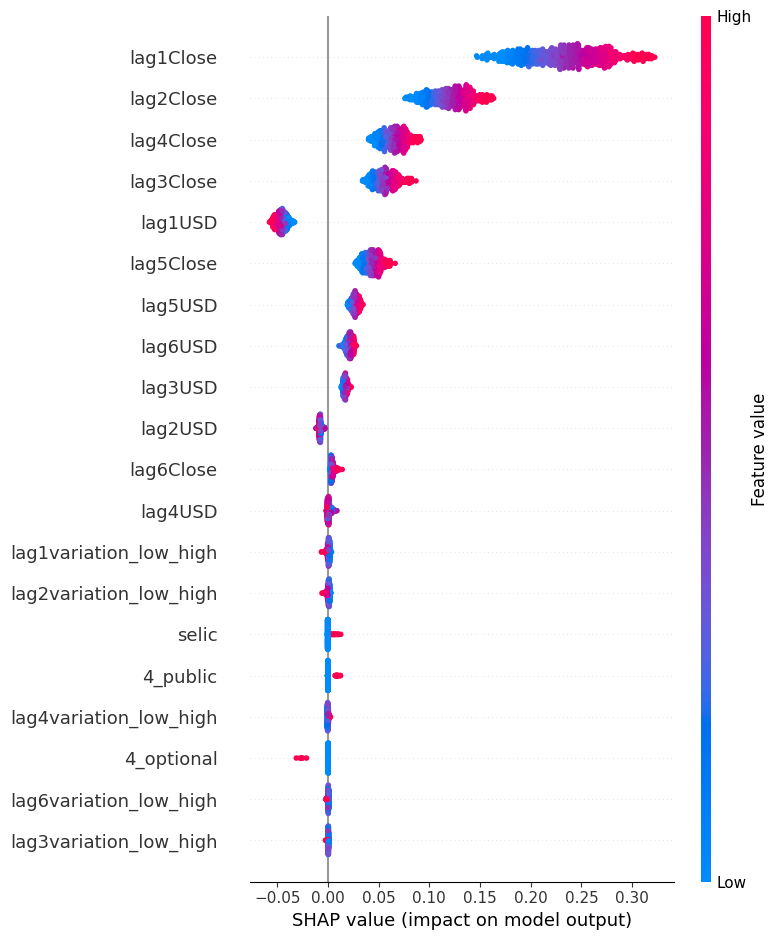

In [ ]:
# plot shap importance
shap.summary_plot(
  shap_values[0],
  sample,
  feature_names=columnnames
)

# Lime Validation

In [ ]:
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
# Set a seed for reproducibility
np.random.seed(42)
# creating an explainer for Lime
explainer = LimeTabularExplainer(trainX,
                                 mode="regression",
                                 feature_names=columnnames,
                                 class_names=['ibv'],
                                 categorical_features=[[0,1,2,3]],
                                 discretize_continuous=True)

In [ ]:
#values 1
sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
np.random.seed(42)
X_sample = testX[sample_idx]#testXnsc[sample_idx]

809


In [ ]:
X_sample.shape

(22,)

809


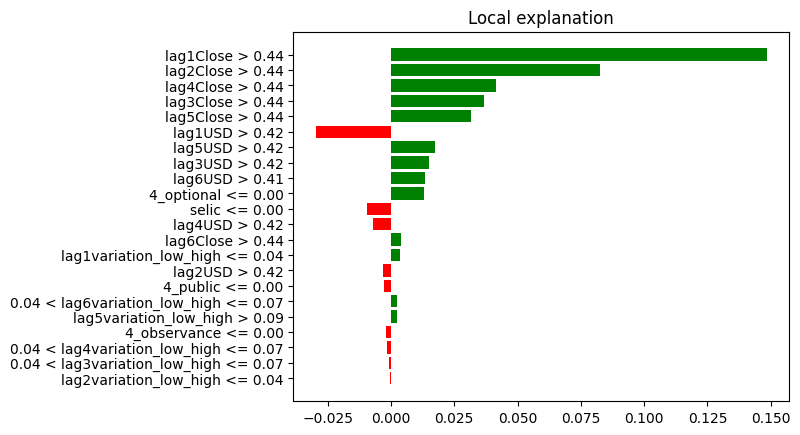

In [ ]:
#first lime to check stability of explanations

sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
np.random.seed(42)
X_sample = testX[sample_idx]#testXnsc[sample_idx]


explanation1 = explainer.explain_instance(X_sample,
                                         bilstm_model.predict,
                                         num_features=(22))


fig = explanation1.as_pyplot_figure()
plt.show()

In [ ]:
scaler.inverse_transform(np.array([0.04,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

1.244736165899001

In [ ]:
order_standardize

['variation_low_high',
 'Close',
 '4_observance',
 '4_optional',
 '4_public',
 'selic',
 'USD']

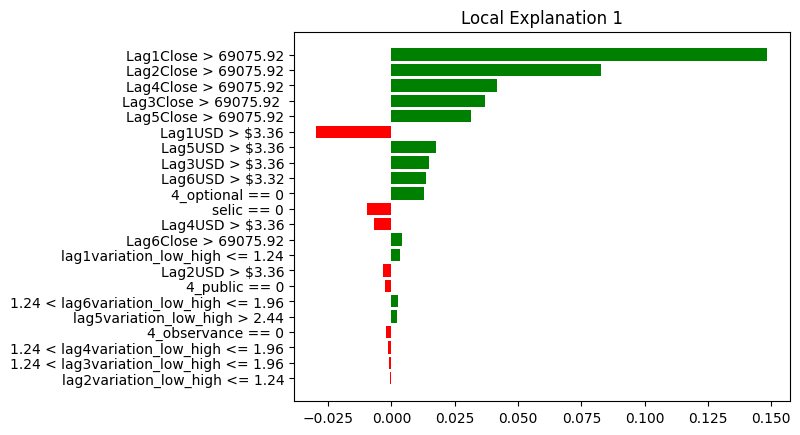

In [ ]:
# inverting normalization in the plot

fig = explanation1.as_pyplot_figure()
lime_ax = fig.gca()

lime_ax.set_yticklabels(['lag2variation_low_high <= 1.24','1.24 < lag3variation_low_high <= 1.96','1.24 < lag4variation_low_high <= 1.96', '4_observance == 0', 'lag5variation_low_high > 2.44','1.24 < lag6variation_low_high <= 1.96','4_public == 0',  'Lag2USD > $3.36','lag1variation_low_high <= 1.24','Lag6Close > 69075.92',  'Lag4USD > $3.36','selic == 0', '4_optional == 0','Lag6USD > $3.32','Lag3USD > $3.36','Lag5USD > $3.36','Lag1USD > $3.36','Lag5Close > 69075.92', 'Lag3Close > 69075.92 ','Lag4Close > 69075.92', 'Lag2Close > 69075.92','Lag1Close > 69075.92'])
plt.title("Local Explanation 1")

# Show the modified Lime plot
plt.show()


In [ ]:
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)

In [ ]:
X_sample

array([0.        , 0.        , 0.        , 0.        , 0.95810995,
       0.97250619, 0.9690209 , 0.95147237, 0.94052812, 0.93069384,
       0.03900328, 0.01922964, 0.05117747, 0.0531948 , 0.09617285,
       0.04929392, 0.80690139, 0.80807314, 0.82741743, 0.82982971,
       0.83426374, 0.83187446])

In [ ]:
testXnsc[809]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.15754000e+05, 1.17051000e+05, 1.16737000e+05, 1.15156000e+05,
       1.14170000e+05, 1.13284000e+05, 1.22084075e+00, 7.46788722e-01,
       1.51270428e+00, 1.56106763e+00, 2.59142107e+00, 1.46754802e+00,
       5.04589987e+00, 5.05100012e+00, 5.13520002e+00, 5.14569998e+00,
       5.16499996e+00, 5.15460014e+00])

809


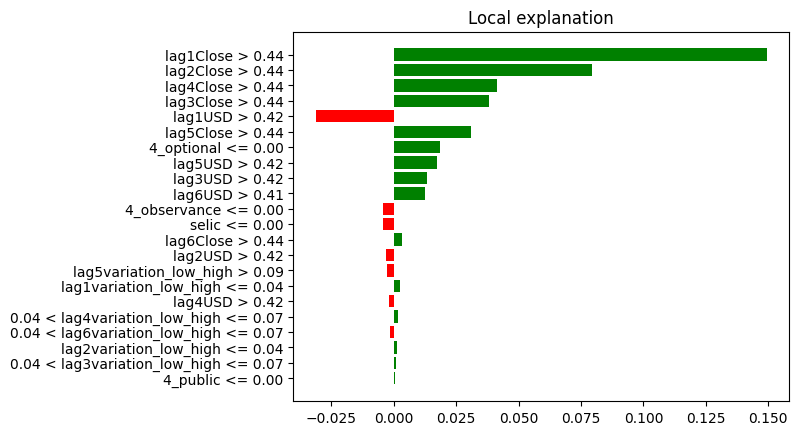

In [ ]:
#second lime to check stability of explanations

np.random.seed(4)
sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
X_sample = testX[sample_idx]#testXnsc[sample_idx]


explanation2 = explainer.explain_instance(X_sample,
                                         bilstm_model.predict,
                                         num_features=(22))


fig = explanation2.as_pyplot_figure()
plt.show()

In [ ]:
scaler.inverse_transform(np.array([0.07,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

1.963954546066836

In [ ]:
order_standardize

['variation_low_high',
 'Close',
 '4_observance',
 '4_optional',
 '4_public',
 'selic',
 'USD']

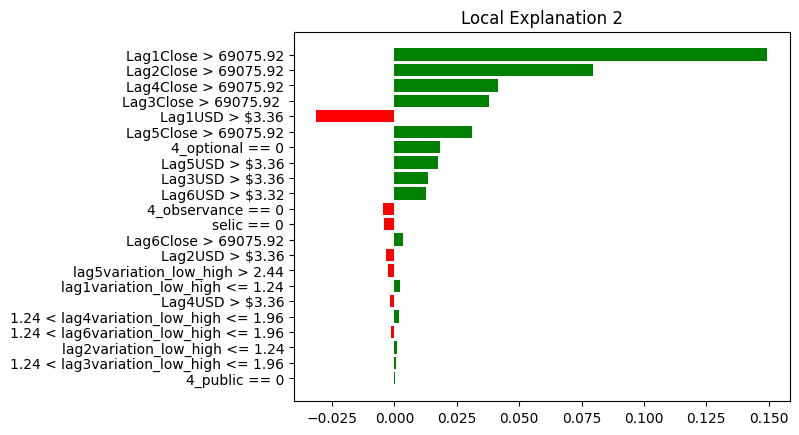

In [ ]:
# view explanations (inverting normality)
fig = explanation2.as_pyplot_figure()
lime_ax = fig.gca()


lime_ax.set_yticklabels(['4_public == 0','1.24 < lag3variation_low_high <= 1.96','lag2variation_low_high <= 1.24','1.24 < lag6variation_low_high <= 1.96','1.24 < lag4variation_low_high <= 1.96','Lag4USD > $3.36','lag1variation_low_high <= 1.24','lag5variation_low_high > 2.44','Lag2USD > $3.36','Lag6Close > 69075.92','selic == 0','4_observance == 0','Lag6USD > $3.32','Lag3USD > $3.36','Lag5USD > $3.36', '4_optional == 0','Lag5Close > 69075.92','Lag1USD > $3.36', 'Lag3Close > 69075.92 ','Lag4Close > 69075.92', 'Lag2Close > 69075.92','Lag1Close > 69075.92'])
plt.title("Local Explanation 2")
# Show the modified Lime plot
plt.show()


809


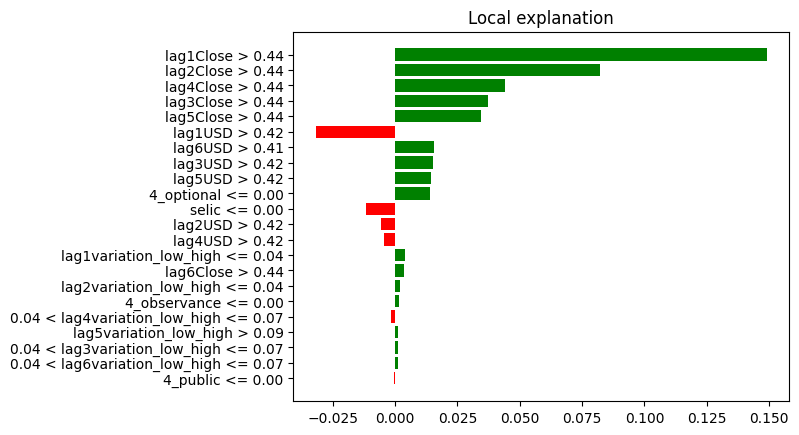

In [ ]:
#third lime to check stability of explanations

np.random.seed(3)
sample_idx = 809#np.random.choice(range(len(testX)), size=(1,))[0]#830
print(sample_idx)
X_sample = testX[sample_idx]#testXnsc[sample_idx]


explanation3 = explainer.explain_instance(X_sample,
                                         bilstm_model.predict,
                                         num_features=(22))



# explanation
fig = explanation3.as_pyplot_figure()
plt.show()

In [ ]:
scaler.inverse_transform(np.array([0.07,0.44,0,0,0,0,0.42]).reshape(1,-1))[0][0]

1.963954546066836

In [ ]:
order_standardize

['variation_low_high',
 'Close',
 '4_observance',
 '4_optional',
 '4_public',
 'selic',
 'USD']

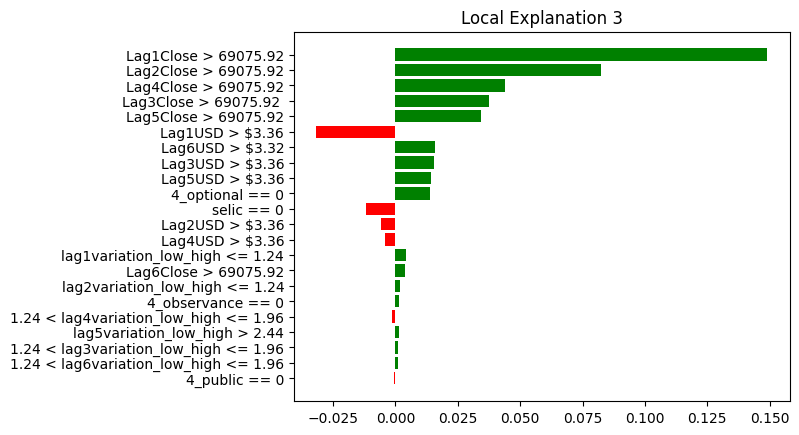

In [ ]:
#inverting normality
fig = explanation3.as_pyplot_figure()
lime_ax = fig.gca()

lime_ax.set_yticklabels(['4_public == 0','1.24 < lag6variation_low_high <= 1.96','1.24 < lag3variation_low_high <= 1.96','lag5variation_low_high > 2.44','1.24 < lag4variation_low_high <= 1.96', '4_observance == 0','lag2variation_low_high <= 1.24',  'Lag6Close > 69075.92','lag1variation_low_high <= 1.24',  'Lag4USD > $3.36','Lag2USD > $3.36','selic == 0', '4_optional == 0','Lag5USD > $3.36','Lag3USD > $3.36','Lag6USD > $3.32','Lag1USD > $3.36','Lag5Close > 69075.92', 'Lag3Close > 69075.92 ','Lag4Close > 69075.92', 'Lag2Close > 69075.92','Lag1Close > 69075.92'])
plt.title("Local Explanation 3")
# Show the modified Lime plot
plt.show()


In [ ]:
list_of_listsexplanation1 = [list(elem) for elem in list(explanation1.local_exp.values())[0]]
for x in list_of_listsexplanation1:
    del x[0]
list_of_listsexplanation1

[[-0.1484527042151943],
 [-0.08273750421667025],
 [-0.04169104710846502],
 [-0.03695434192714649],
 [-0.03147044210100555],
 [0.029631560834857077],
 [-0.017590705863175193],
 [-0.014848891827502842],
 [-0.013568059439475581],
 [-0.012928354181866138],
 [0.009472587993028357],
 [0.006951934217551096],
 [-0.004087451249783649],
 [-0.0034797687261688393],
 [0.0032707160453771134],
 [0.002559065425840313],
 [-0.0024526360735628635],
 [-0.00220563717900962],
 [0.0021330335984757354],
 [0.001477590492229618],
 [0.0007801037766243953],
 [0.0004878701123206595]]

In [ ]:
explanations_first = np.array(list_of_listsexplanation1).reshape(-1)

In [ ]:
list_of_listsexplanation2 = [list(elem) for elem in list(explanation2.local_exp.values())[0]]
for x in list_of_listsexplanation2:
    del x[0]



explanations_2 = np.array(list_of_listsexplanation2).reshape(-1)


In [ ]:
list_of_listsexplanation3 = [list(elem) for elem in list(explanation3.local_exp.values())[0]]
for x in list_of_listsexplanation3:
    del x[0]
explanations_3 = np.array(list_of_listsexplanation3).reshape(-1)

In [ ]:
print(explanations_3.shape)
print(explanations_2.shape)

(22,)
(22,)


In [ ]:
explanations_full_df = pd.DataFrame({"exp1":explanations_first,"exp2":explanations_2,"exp3":explanations_3})

In [ ]:
explanations_full_df.head()

,exp1,exp2,exp3
0,-0.148453,-0.149437,-0.149048
1,-0.082738,-0.079590,-0.082288
2,-0.041691,-0.041347,-0.044032
3,-0.036954,-0.038105,-0.037426
4,-0.031470,0.031253,-0.034416


#Statistical Tests

In [ ]:

from scipy.stats import shapiro

#make this example reproducible
np.random.seed(1)

#perform Shapiro-Wilk test for normality
print(shapiro(explanations_full_df['exp1']),"\n",
shapiro(explanations_full_df['exp2']),"\n",
shapiro(explanations_full_df['exp3']))#no evidence to say that data follows a normal distribution, hence we reject the null hypothesis going for non parametrical test


ShapiroResult(statistic=0.7198877930641174, pvalue=3.54247385985218e-05) 
 ShapiroResult(statistic=0.7091144919395447, pvalue=2.5615476261009462e-05) 
 ShapiroResult(statistic=0.729864239692688, pvalue=4.8120436986209825e-05)


In [ ]:
from scipy.stats import kruskal

kruskal(explanations_full_df['exp1'], explanations_full_df['exp2'], explanations_full_df['exp3'])#we don't have evidence to say that at least one tratment is different


KruskalResult(statistic=0.08215122733440694, pvalue=0.9597565564912021)

In [ ]:
X_sample#id 188 has dummy 1

array([0.        , 0.        , 0.        , 0.        , 0.95810995,
       0.97250619, 0.9690209 , 0.95147237, 0.94052812, 0.93069384,
       0.03900328, 0.01922964, 0.05117747, 0.0531948 , 0.09617285,
       0.04929392, 0.80690139, 0.80807314, 0.82741743, 0.82982971,
       0.83426374, 0.83187446])

In [ ]:
columnnames

array(['4_observance', '4_optional', '4_public', 'selic', 'lag1Close',
       'lag2Close', 'lag3Close', 'lag4Close', 'lag5Close', 'lag6Close',
       'lag1variation_low_high', 'lag2variation_low_high',
       'lag3variation_low_high', 'lag4variation_low_high',
       'lag5variation_low_high', 'lag6variation_low_high', 'lag1USD',
       'lag2USD', 'lag3USD', 'lag4USD', 'lag5USD', 'lag6USD'],
      dtype=object)